
CONFIGURACION 1: Soporte mínimo = 0.035
 Soporte                           itemsets
0.052660         (mineral water, chocolate)
0.039195             (spaghetti, chocolate)
0.036395               (eggs, french fries)
0.050927              (mineral water, eggs)
0.036528                  (spaghetti, eggs)
0.035729 (mineral water, frozen vegetables)
0.040928       (mineral water, ground beef)
0.039195           (spaghetti, ground beef)
0.047994              (mineral water, milk)
0.035462                  (spaghetti, milk)
0.059725         (spaghetti, mineral water)

CONFIGURACION 1: Frecuencia mínima = 262.535
 Frecuencia                           itemsets
        395         (mineral water, chocolate)
        294             (spaghetti, chocolate)
        273               (eggs, french fries)
        382              (mineral water, eggs)
        274                  (spaghetti, eggs)
        268 (mineral water, frozen vegetables)
        307       (mineral water, ground beef)
        2

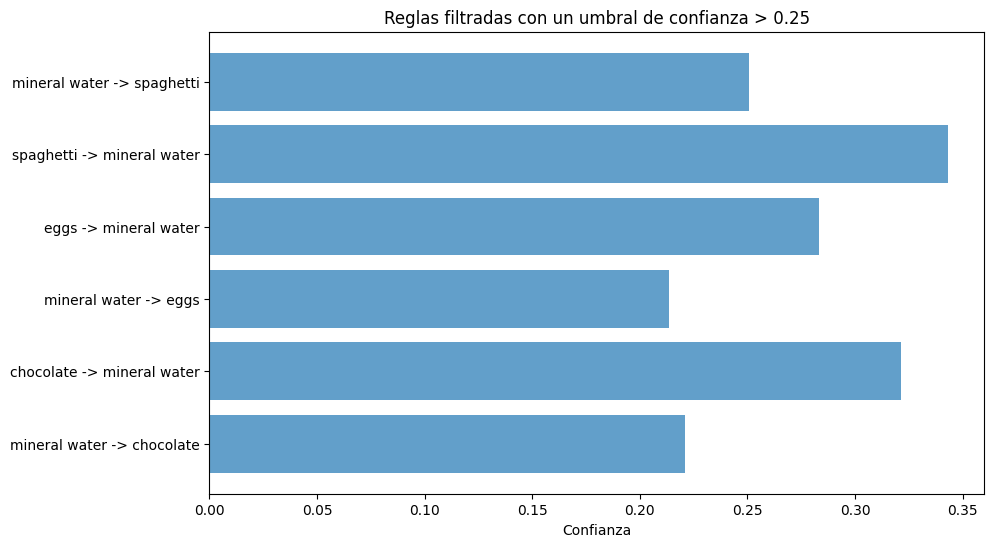

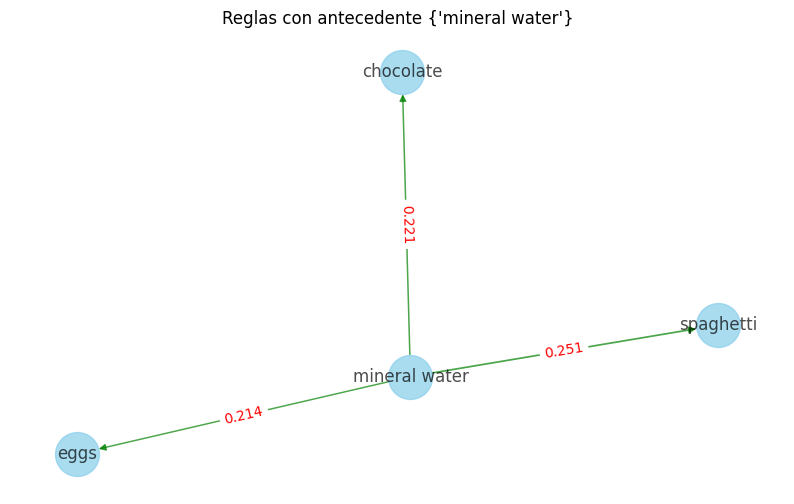

In [ ]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Cargar el conjunto de datos
df = pd.read_csv('Market_Basket_Optimisation.csv', sep=';', header=None)

# Convertir el dataframe en listas de transacciones
transaction_list = df[0].str.split(',')

# Codificar las transacciones
encoder = TransactionEncoder()
onehot = encoder.fit_transform(transaction_list)
onehot_df = pd.DataFrame(onehot, columns=encoder.columns_)

# Número de observaciones
num_filas = len(transaction_list)

# Configuraciones para el soporte mínimo y la frecuencia mínima
configurations = [
    {'min_support': 0.035, 'min_frequency': 0.035*num_filas},
    {'min_support': 0.045, 'min_frequency': 0.045*num_filas},
    {'min_support': 0.05, 'min_frequency': 0.05*num_filas}
]

# Reglas con antecedente
antecedente_buscado = {'mineral water'}
# Definición de la función para encontrar reglas con antecedente
def encontrar_reglas_con_antecedente(rules, antecedente):
    return rules[rules['antecedents'].apply(lambda x: antecedente.issubset(x))]

# Iterar sobre las configuraciones de soporte y frecuencia
for i, config in enumerate(configurations, start=1):
    min_support = config['min_support']
    min_frequency = config['min_frequency']

    # CALCULAR SEGÚN SOPORTE
    print(f'\nCONFIGURACION {i}: Soporte mínimo = {min_support}')
    frequent_itemsets_s = apriori(onehot_df, min_support=min_support, use_colnames=True)

    # Filtrar itemsets redundantes
    filtered_itemsets = []
    for idx, itemset in frequent_itemsets_s.iterrows():
        is_redundant = False
        for idx2, itemset2 in frequent_itemsets_s.iterrows():
            if idx != idx2 and set(itemset['itemsets']).issubset(set(itemset2['itemsets'])):
                is_redundant = True
                break
        if not is_redundant:
            filtered_itemsets.append(itemset)

    # Retener solo los itemsets de mayor tamaño en caso de igual soporte
    max_len = max(len(itemset['itemsets']) for itemset in filtered_itemsets)
    frequent_itemsets_s_filtered = [itemset for itemset in filtered_itemsets if len(itemset['itemsets']) == max_len]

    print(pd.DataFrame(frequent_itemsets_s_filtered).rename(columns={'support': 'Soporte'}).to_string(index=False))  # Imprimir sin índices

    # CALCULAR SEGÚN FRECUENCIA
    print(f'\nCONFIGURACION {i}: Frecuencia mínima = {min_frequency}')
    frequent_itemsets_f = frequent_itemsets_s[frequent_itemsets_s['support'] * num_filas >= min_frequency]

    # Filtrar itemsets redundantes y retener solo los de mayor tamaño
    filtered_itemsets_f = []
    for idx, itemset in frequent_itemsets_f.iterrows():
        is_redundant = False
        for idx2, itemset2 in frequent_itemsets_f.iterrows():
            if idx != idx2 and set(itemset['itemsets']).issubset(set(itemset2['itemsets'])):
                is_redundant = True
                break
        if not is_redundant:
            filtered_itemsets_f.append(itemset)

    # Retener solo los itemsets de mayor tamaño en caso de igual soporte
    max_len_f = max(len(itemset['itemsets']) for itemset in filtered_itemsets_f)
    frequent_itemsets_f_filtered = [itemset for itemset in filtered_itemsets_f if len(itemset['itemsets']) == max_len_f]

    # Convertir la lista de itemsets filtrados a un DataFrame
    frequent_itemsets_f_filtered_df = pd.DataFrame(frequent_itemsets_f_filtered)

    # Recalculando las frecuencias de los itemsets para la salida
    frecuencias = []
    for itemset in frequent_itemsets_f_filtered_df['itemsets']:
        # Calcular la frecuencia del itemset
        frequency = sum(onehot_df[itemset].all(axis=1))
        frecuencias.append(frequency)

    # Agregar la columna de frecuencia al DataFrame de itemsets frecuentes filtrados
    frequent_itemsets_f_filtered_df['Frecuencia'] = frecuencias

    # Imprimir DataFrame con la columna 'Frecuencia' primero
    print(frequent_itemsets_f_filtered_df[['Frecuencia', 'itemsets']].to_string(index=False))

    # Listar todas las reglas que sean de alta confianza.
    frequent_itemsets_s = frequent_itemsets_s[frequent_itemsets_s['itemsets'].apply(len) > 0]

    # Calcular reglas de asociación
    rules = association_rules(frequent_itemsets_s, metric="confidence", min_threshold=0.2)
    rules_a = association_rules(frequent_itemsets_s, metric="confidence", min_threshold=0) # Para según antecedente

    # Obtener el tamaño del último item
    tamano_ultimo_item = max(frequent_itemsets_s['itemsets'].apply(len))

    # Filtrar reglas de asociación por tamaño del último item
    reglas_filtradas = rules[(rules['antecedents'].apply(len) + rules['consequents'].apply(len)) == tamano_ultimo_item]

    # Imprimir las reglas de asociación filtradas por tamaño
    if not reglas_filtradas.empty:
        print(f"\nReglas de Asociación con confianza > 0.2:")
        print(f"{'Regla de asociación':<40} {'Confianza':<20}")
        for index, row in reglas_filtradas.iterrows():
            antecedente = set(row['antecedents'])
            consecuente = set(row['consequents'])
            confianza = row['confidence']
            print(f"{antecedente} -> {consecuente} : {confianza}")


    # Reglas con antecedente
    reglas_con_antecedente = encontrar_reglas_con_antecedente(rules_a, antecedente_buscado)

    if not reglas_con_antecedente.empty:
        print(f"\nReglas de Asociación con antecedente {antecedente_buscado}:")
        print(f"{'Regla de asociación':<40} {'Confianza':<20}")
        for index, row in reglas_con_antecedente.iterrows():
            antecedente = set(row['antecedents'])
            consecuente = set(row['consequents'])
            confianza = row['confidence']
            print(f"{antecedente} -> {consecuente} : {confianza}")
    else:
        print(f"No se encontraron reglas con antecedente {antecedente_buscado}.")



# 5. REPRESENTACION GRAFICA DE LAS REGLAS
# Gráfico de barras
# 5.1. Segun la confianza
def format_rule(rules):

    return ', '.join(list(rules))
plt.figure(figsize=(10, 6))
plt.barh(range(len(rules)), rules['confidence'], align='center', alpha=0.7)
plt.yticks(range(len(rules)), [format_rule(ant) + ' -> ' + format_rule(con) for ant, con in zip(rules['antecedents'], rules['consequents'])])
plt.xlabel('Confianza')
plt.title(f'Reglas filtradas con un umbral de confianza > 0.25')
plt.show()

# Grafo dirigido
# 5.2. Segun un antecedente

def frozenset_to_string(fset):
    return ', '.join(list(fset))
G = nx.DiGraph()

# Filtrar reglas que contienen el antecedente dado
filtered_rules = rules_a[rules_a['antecedents'].apply(lambda x: antecedente_buscado.issubset(x))]

for _, row in filtered_rules.iterrows():
    antecedent_str = frozenset_to_string(row['antecedents'])
    consequent_str = frozenset_to_string(row['consequents'])
    confidence = round(row['confidence'], 3)  # Redondeo a 3 decimales
    G.add_edge(antecedent_str, consequent_str, weight=confidence, label=str(confidence))

pos = nx.spring_layout(G)
_, ax = plt.subplots(figsize=(10, 6))
nx.draw(G, pos, ax=ax, with_labels=True, node_size=1000, node_color='skyblue', font_size=12,
        edge_color='g', width=[edata['weight'] * 5 for u, v, edata in G.edges(data=True)], alpha=0.7)

# Se agregan las etiquetas de la confianza en los bordes
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

ax.set_title(f'Reglas con antecedente {antecedente_buscado}')
plt.show()

Tras haber realizado esta práctica y haber estudiado las variables de distintas maneras, sabemos que en el contexto del análisis de reglas de asociación, el soporte se refiere a la proporción de transacciones que contienen un conjunto específico de ítems, mientras que la frecuencia se refiere al número total de veces que aparece ese conjunto en todas las transacciones. Por lo tanto, en este caso, el uso del soporte y la frecuencia de soporte es esencialmente lo mismo, ya que el soporte se calcula como la frecuencia del conjunto de ítems dividido por el número total de transacciones. Al observar los resultados obtenidos, se confirma esta idea, ya que los valores de soporte y frecuencia son idénticos para cada conjunto de ítems.

Además de estudiar las variables con los datos obtenidos, hemos elegido dos tipos diferentes de gráficos para facilitar la interpretación. Primero, representamos las confianzas de las distintas reglas de asociación según una confianza mínima mediante un gráfico de barras horizontales, donde podemos comparar todas las confianzas obtenidas de manera sencilla. Dentro de nuestra tercera configuración, la regla con mayor confianza es {spaguetti} -> {mineral water}, mientras que la regla con menor confianza es {milk} -> {mineral water}. En segundo lugar, elegimos un diagrama de red para representar las reglas según un antecedente, donde el antecedente elegido queda en el centro y los precedentes en el exterior, representando la confianza de uno a otro en el centro.

Al aumentar el valor del soporte mínimo o de la frecuencia mínima, observamos que algunas reglas desaparecen debido a que no cumplen con el nuevo umbral establecido, al igual que si aumentamos el valor de la confianza, puesto que estamos restringiendo cada vez más la base de datos. Por ejemplo, si incrementamos el soporte mínimo, las reglas que tenían un soporte menor al nuevo valor mínimo ya no serán consideradas. Un ejemplo claro es si comparamos la configuración 1 con la 2, donde desaparece la asociación entre las variables 'ground beef' y 'mineral water'. Sin embargo, si cambiáramos el separador utilizado para leer el documento .csv (por ejemplo, cambiando de ';' a ','), no podríamos obtener las reglas de asociación, ya que estaríamos filtrando por frecuencia y soporte de cada elemento individualmente y no como un conjunto total según las observaciones de las transacciones que hemos estudiado.

Al analizar las reglas de asociación y los patrones encontrados en las tres configuraciones, podemos observar ciertas similitudes y generalizar el comportamiento de los clientes del supermercado. Encontramos que el agua mineral es un producto central, ya que aparece como uno de los elementos más comunes en todas las configuraciones, lo que sugiere que es popular entre los clientes y se compra con frecuencia en combinación con otros productos. Además, se observa una asociación frecuente entre productos como chocolate, huevos, leche y carne molida con el agua mineral y/o espaguetis, lo que sugiere que estos productos tienden a ser comprados juntos, indicando una posible complementariedad entre ellos.

La presencia de diferentes combinaciones de productos en las reglas de asociación sugiere que los clientes tienen preferencias diversas y pueden comprar una variedad de productos en una sola visita al supermercado. En general, los clientes muestran ciertos patrones de compra, como la compra frecuente de agua mineral junto con otros productos como chocolate, huevos, etc. Sin embargo, también muestran variedad en sus elecciones de compra, lo que indica que las preferencias individuales y las necesidades pueden variar entre los clientes. Este estudio podría ser muy útil para el supermercado, ya que proporciona herramientas para el emplazamiento de productos, la creación de ofertas y la comprensión de las tendencias de compra de los clientes.


